In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

# To prevent CUBLAS_STATUS_ALLOC_FAILED problem in tensorflow 2, the follwing codes are necessary.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Autoencoders

An autoencoder will attempt to find a representation or piece of code in order to perform useful transformations on the input data. As an example, when denoising autoencoders, a neural network will attempt to find a code that can be used to transform noisy data into clean data.

Autoencoders will learn the code automatically from the data alone without human labeling. As such, autoencoders can be classified under unsupervised learning algorithms.

An autoencoder will encode the input distribution into a low-dimensional tensor, which usually takes the form of a vector. This will approximate the hidden structure that is commonly referred to as the latent representation, code, or vector. This process constitutes the encoding part. The latent vector will then be decoded by the decoder part to recover the original input.

As a result of the latent vector being a low-dimensional compressed representation of the input distribution, it should be expected that the output recovered by the decoder can only approximate the input. The dissimilarity between the input and the output can be measured by a loss function.

They're a key tool in understanding the advanced topics of deep learning as they give us a low-dimensional representation of data that is suitable for density estimation. Furthermore, it can be efficiently processed to perform structural operations on the input data. Common operations include denoising, colorization, feature-level arithmetic, detection, tracking, and segmentation, to name just a few.

Firstly, we need to be made aware that an autoencoder has two operators, these being:

 * Encoder : This transforms the input, x , into a low-dimensional latent vector, $z = f(x)$ . Since the latent vector is of low dimension, the encoder is forced to learn only the most important features of the input data. For example, in the case of MNIST digits, the important features to learn may include writing style, tilt angle, roundness of stroke, thickness, and so on. Essentially, these are the most important bits of information needed to represent the digits zero to nine.
 
  * Decoder : This tries to recover the input from the latent vector, $g(z) = \tilde{x}$ .
  
 Although the latent vector has a low dimension, it has a sufficient size to allow the decoder to recover the input data.
 

 
 The goal of the decoder is to make image as close as possible to $x$ . Generally, both the encoder and decoder are non-linear functions. The dimension of z is a measure of the number of salient features it can represent. The dimension is usually much smaller than the input dimensions for efficiency and in order to constrain the latent code to learn only the most salient properties of the input distribution.

A suitable loss function, $\mathcal{L}(x,\tilde{x})$, is a measure of how dissimilar the input, x , is from the output, which is the recovered input, $\tilde{x}$

As shown in the following equation, the mean squared error (MSE) is an example of such a loss function:

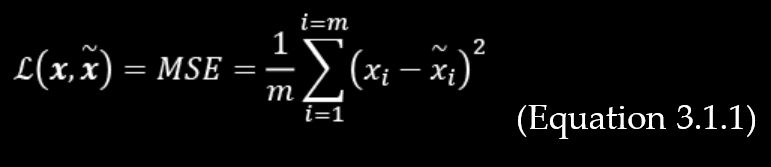

m is the output dimension (for example, in MNIST m = width × height × channels = 28 × 28 × 1 = 784 ). x i and image are the elements of x and image , respectively. Since the loss function is a measure of dissimilarity between the input and output, we're able to use alternative reconstruction loss functions such as binary cross entropy or the structural similarity index (SSIM).

Similar to other neural networks, an autoencoder tries to make this error or loss function as small as possible during training.

 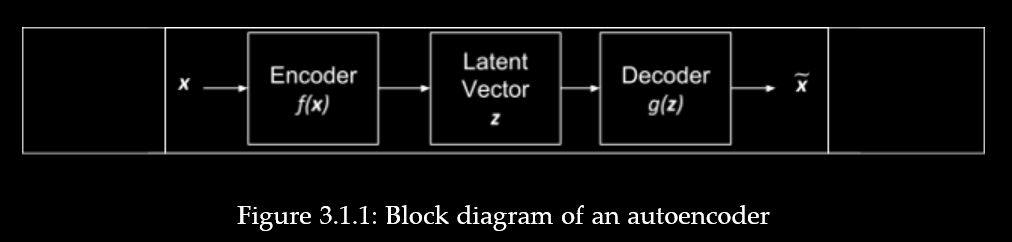
 
The encoder is a function that compresses the input, $x$ , into a low-dimensional latent vector, $z$ . This latent vector represents the important features of the input distribution. The decoder then tries to recover the original input from the latent vector in the form of $\tilde{x}$.

To put the autoencoder into context, $x$ can be an MNIST digit that has a dimension of 28 × 28 × 1 = 784. The encoder transforms the input into a low-dimensional $z$ that can be a 16-dimension latent vector. The decoder will attempt to recover the input in the form of image from $z$ .

 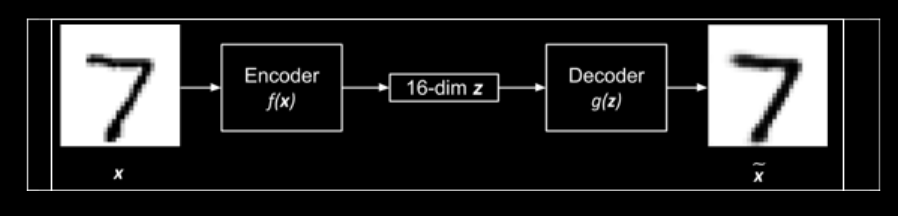
 


## Building an autoencoder for mnist data using Keras

## Stage 1 : Encoder 

The encoder is a stack of two Conv2D . The final stage is a Dense layer with 16 units to generate the latent vector.

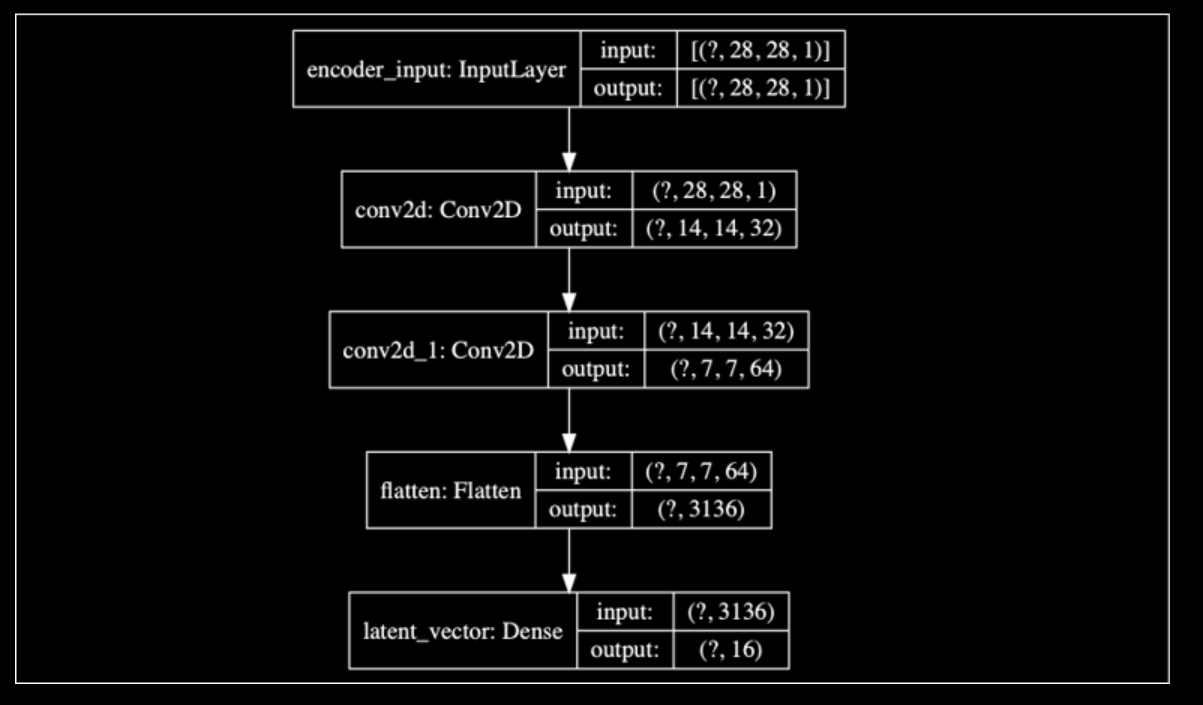

In [4]:
# Step 1: Data Preparation

(x_train, _), (x_test, _) = mnist.load_data()

# data preprocessing: Reshape and normalization

image_size=x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train/255.
x_test = x_test/255.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


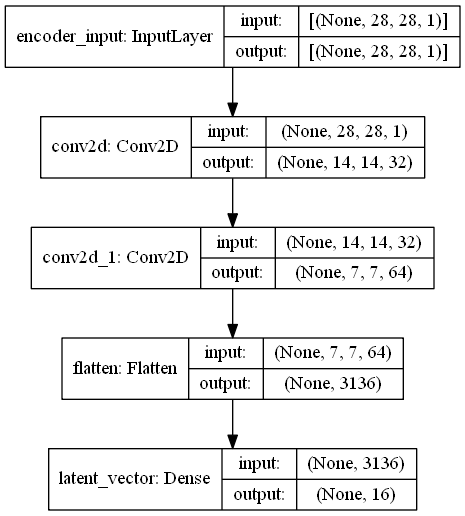

In [7]:
# Step 2: Autoencoder model construction

#  Set those hyperparameters

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16 # encoder/decoder number of CNN layers and filters per layer
layer_filters = [32,64]

# Encoder Model

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs # stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters = filters, kernel_size = kernel_size,
               activation = 'relu',
               strides =2,
               padding = 'same') (x)
    
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape.
# The shape is (7,7,64) which is processed by the decoder back to (28,28,1)

shape = K.int_shape(x) # . The shape of the output of the last Conv2D is saved to compute the dimensions of the decoder 
                       # input layer for easy reconstruction of the MNIST image: shape = K.int_shape(x)

# generate latent vector

x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

# instantiate encoder model

encoder = Model(inputs, latent, name = 'encoder')

encoder.summary()

plot_model(encoder, show_shapes =True)

## Stage 2 (Decoder)

The decoder decompresses the latent vector in order to recover the MNIST digit. The decoder input stage is a Dense layer that will accept the latent vector. The number of units is equal to the product of the saved Conv2D output dimensions from the encoder. This is done so that we can easily resize the output of the Dense layer for Conv2DTranspose to finally recover the original MNIST image dimensions.

The decoder is made of a stack of three Conv2DTranspose . In our case, we're going to use a Transposed CNN (sometimes called deconvolution ), which is more commonly used in decoders. We can imagine transposed CNN ( Conv2DTranspose) as the reversed process of CNN.

In a simple example, if the CNN converts an image into feature maps, the transposed CNN will produce an image given feature maps.

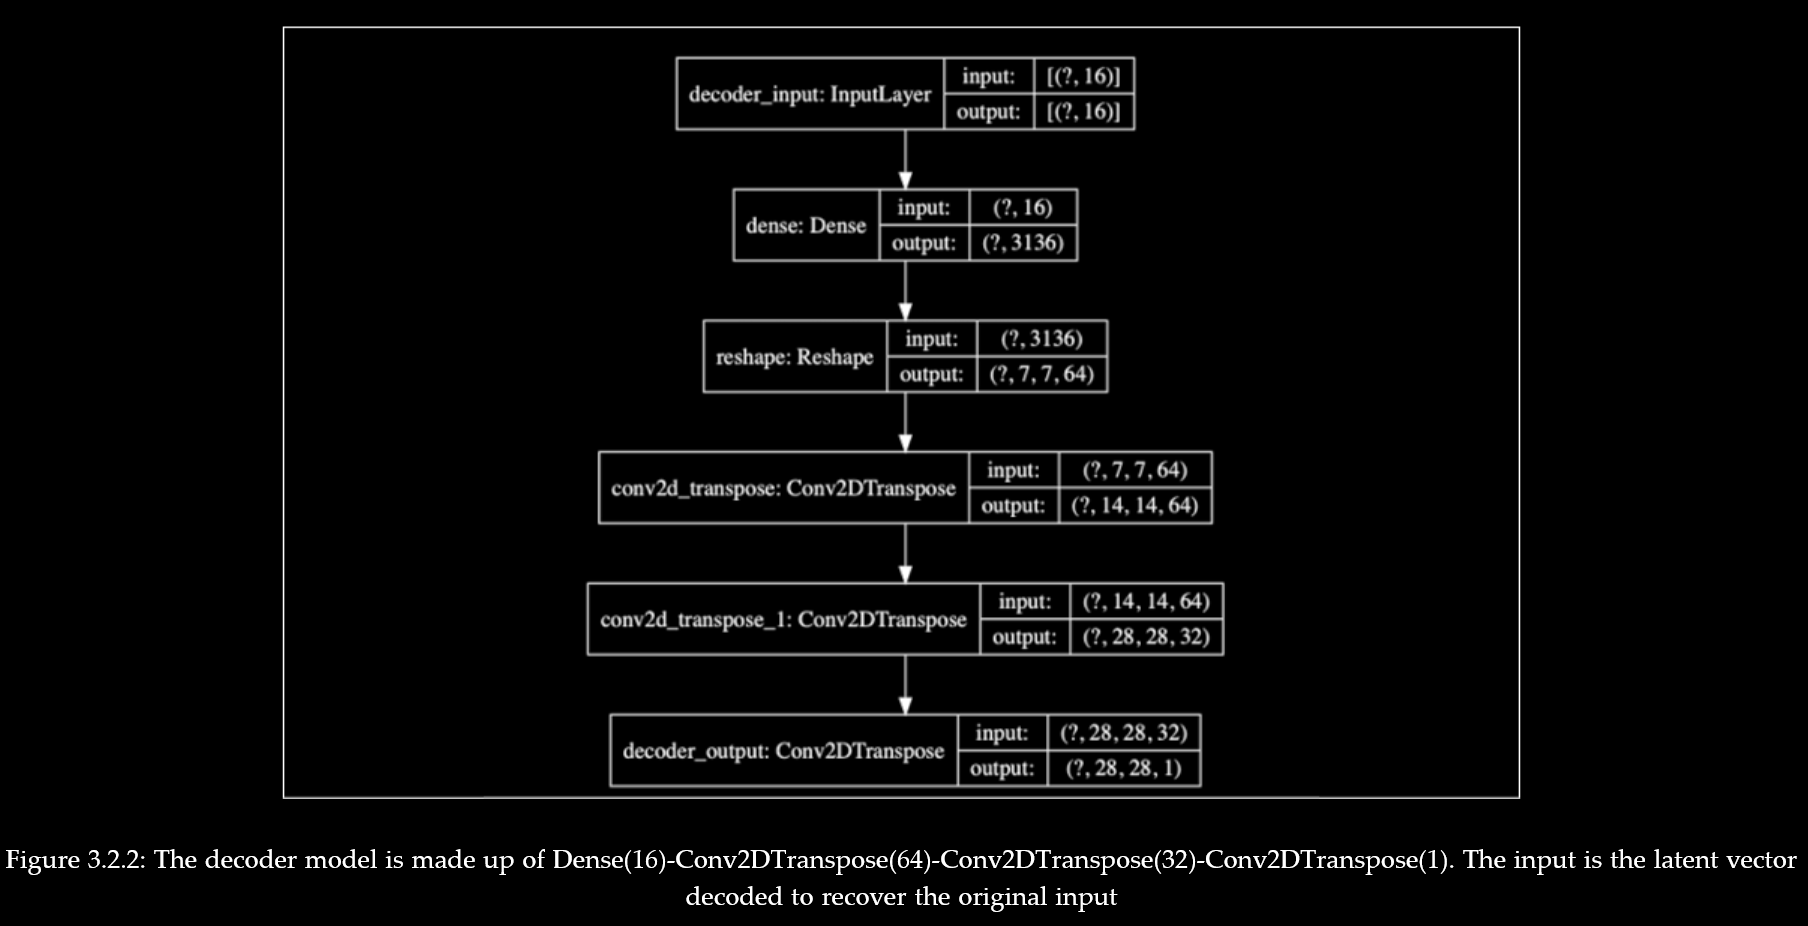

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

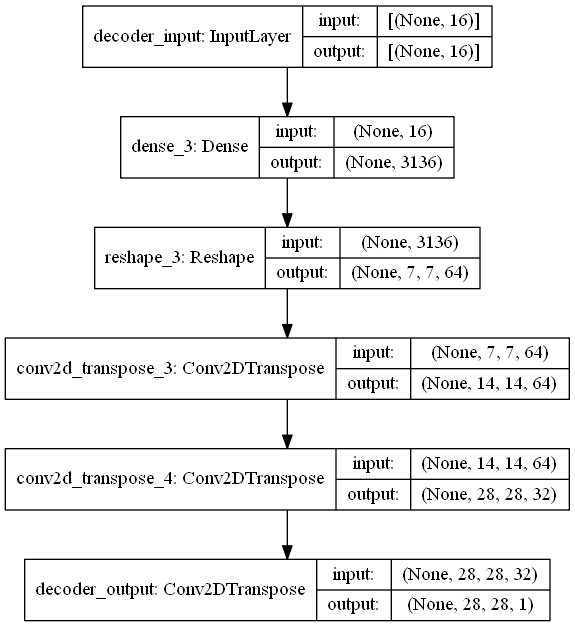

In [13]:
# Decoder Model

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# use the shape (7, 7, 64) that was earlier saved

x= Dense(shape[1]* shape[2] * shape[3]) (latent_inputs)

# from vector to suitable shape for transposed conv

x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64) - Conv2DTranspose(32)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size,
               activation = 'relu',
               strides =2,
               padding = 'same') (x)

# reconstruct the input
    outputs = Conv2DTranspose(filters = 1, kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output') (x)

# instantiate decoder model

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

plot_model(decoder, show_shapes=True)

## Build autoencoder = encoder + decoder

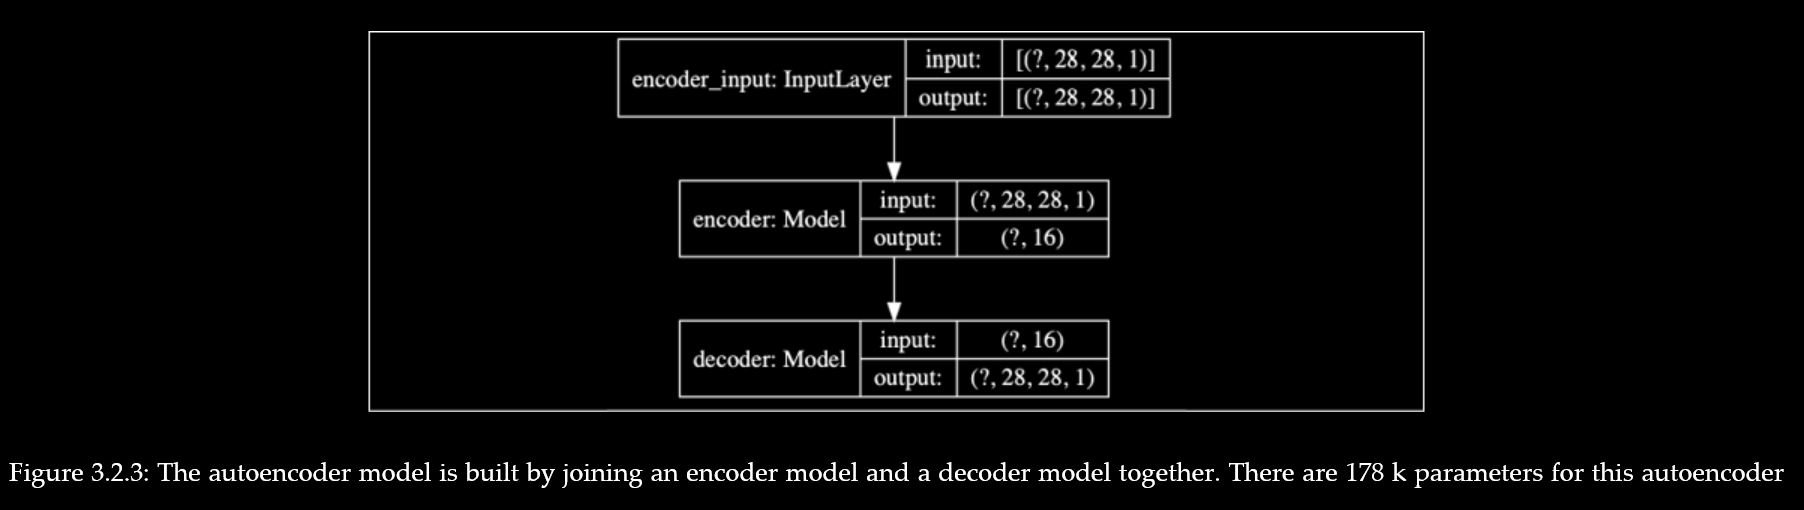

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


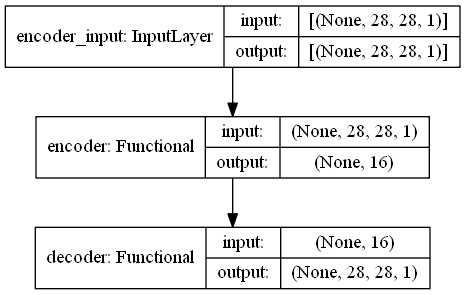

In [14]:
# Model autoencoder = encoder + decoder

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, show_shapes=True)

In [15]:
# Step 3: Model Compile

autoencoder.compile(loss='mse', optimizer='adam')

# Step 4: Model Fit

autoencoder.fit(x_train, 
                x_train,
                validation_data=(x_test,x_test),
                epochs=1,
                batch_size=batch_size)


1875/1875 [==============================] - 10s 4ms/step - loss: 0.0427 - val_loss: 0.0102


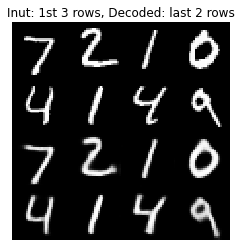

In [19]:
# Step 5: Model evaluation & prediction

# predict the autoencoder output from test validation_data

x_decoded = autoencoder.predict(x_test)

# display the first 8 test input and decoded images

images = np.concatenate([x_test[:8], x_decoded[:8]])
images=images.reshape((4,4, image_size, image_size))
images = np.vstack([np.hstack(i) for i in  images])

plt.figure()
plt.axis('off')
plt.title('Inut: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(images, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

## At this point, we may be wondering: how can we visualize the latent vector in space?

A simple method for visualization is to force the autoencoder to learn the MNIST digits features using a 2-dim latent vector. From there, we're able to project this latent vector on a two dimensional space in order to see how the MNIST latent vectors are distributed.

Figure 3.2.5 and Figure 3.2.6 show the distribution of MNIST digits as a function of latent code dimensions.

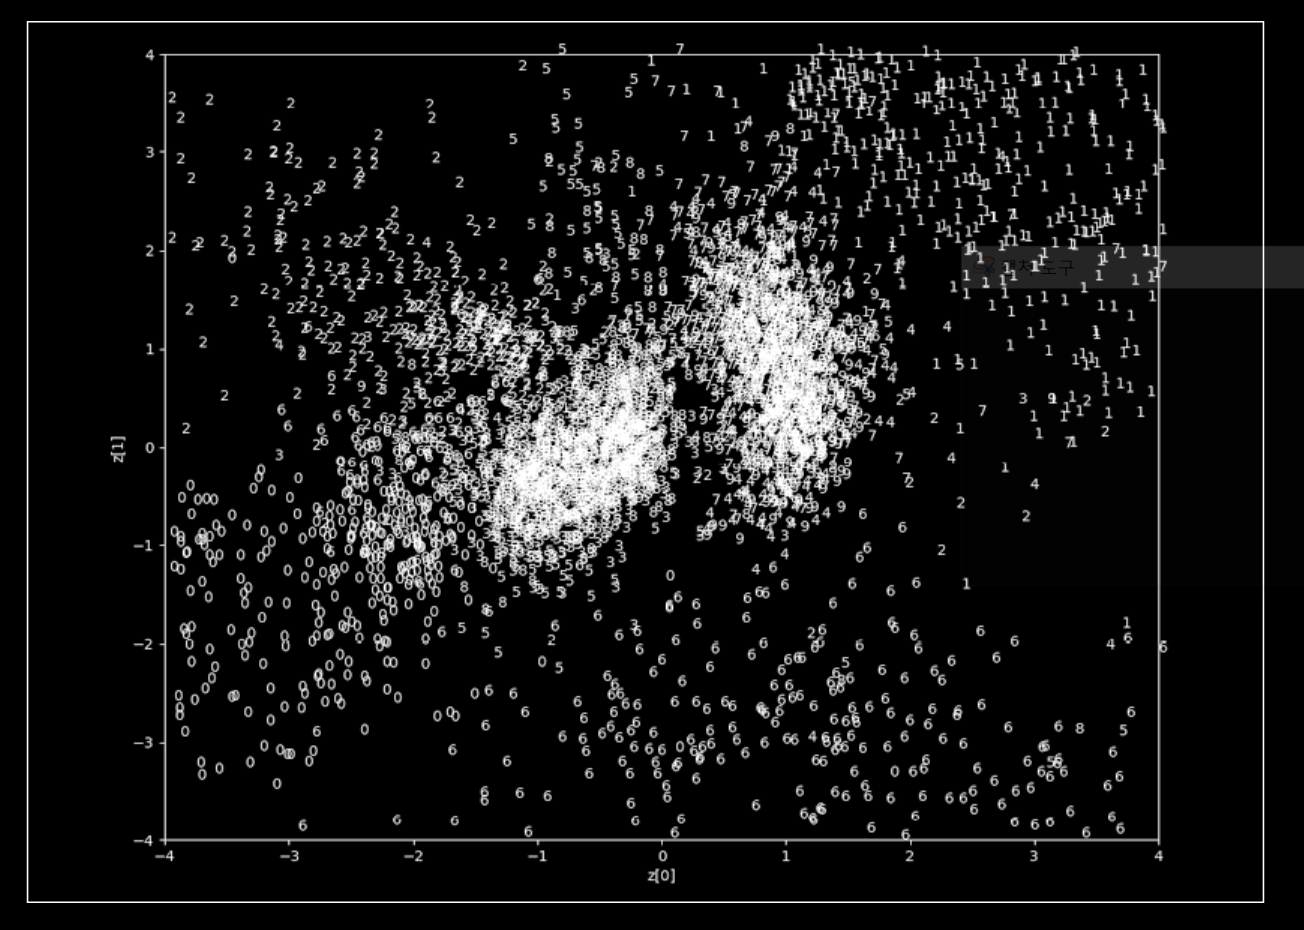

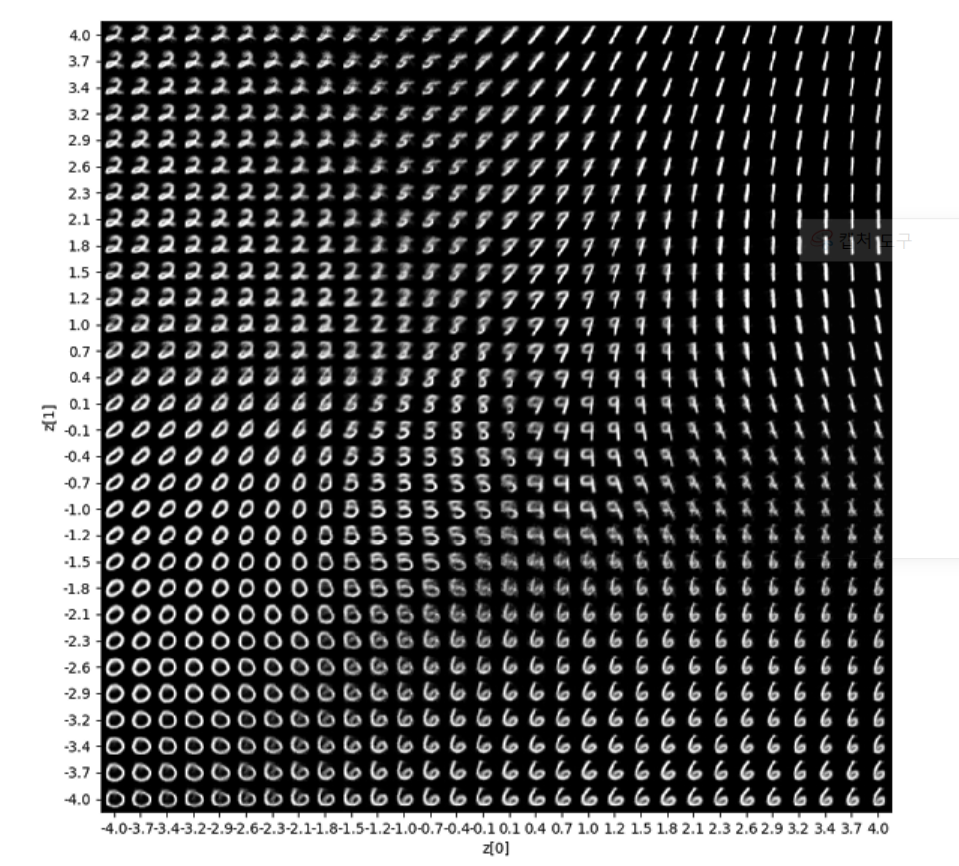